In [1]:
%matplotlib inline

http://alleninstitute.github.io/AllenSDK/_static/examples/nb/mouse_connectivity.html

In [2]:
import pandas as pd
import numpy as np
import nibabel as nb
from nighres.io import io_mesh
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

### Import template and annotation file and save to nifti

In [3]:
mcc = MouseConnectivityCache(manifest_file=
                             '/home/julia/data/gradients/atlas/allen_api/mouse_connectivity_manifest.json')

In [4]:
template, template_info = mcc.get_template_volume('/home/julia/data/gradients/atlas/allen_api/template.nrrd')
annot, annot_info = mcc.get_annotation_volume('/home/julia/data/gradients/atlas/allen_api/annotation.nrrd')

In [ ]:
nb.Nifti1Image(annot, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/annotation.nii.gz')
nb.Nifti1Image(template, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/template.nii.gz')

### Access information from structure tree

In [7]:
structure_tree = mcc.get_structure_tree()
structure_tree.get_name_map()

### Download and save masks and meshes for brain and isocortex

In [8]:
structures = structure_tree.get_structures_by_name(['Isocortex', 'root'])
pd.DataFrame(structures)

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
1,root,1,0,997,root,[997],[691663206],"[255, 255, 255]"


In [9]:
cortex_mask, cm_info = mcc.get_structure_mask(315, '/home/julia/data/gradients/atlas/allen_api/cortex.nrrd')
root_mask, root_info = mcc.get_structure_mask(997, '/home/julia/data/gradients/atlas/allen_api/brain.nrrd')

In [ ]:
nb.Nifti1Image(cortex_mask, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/cortex.nii.gz')
nb.Nifti1Image(root_mask, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/brain.nii.gz')

In [ ]:
cortex_mesh=mcc.get_structure_mesh(315, '/home/julia/data/gradients/atlas/allen_api/cortex_mesh.obj')
root_mesh=mcc.get_structure_mesh(997, '/home/julia/data/gradients/atlas/allen_api/brain_mesh.obj')

In [ ]:
io_mesh.save_mesh_geometry('/home/julia/data/gradients/atlas/allen_api/cortex_mesh.vtk',
                           {"points":cortex_mesh[0], "faces":cortex_mesh[2]})
io_mesh.save_mesh_geometry('/home/julia/data/gradients/atlas/allen_api/brain_mesh.vtk',
                           {"points":root_mesh[0], "faces":root_mesh[2]})

Also download cerebral cortex, which includes the hippocampus

In [10]:
pd.DataFrame(structure_tree.get_structures_by_name(['Cerebral cortex']))

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,CTX,1,3,688,Cerebral cortex,"[997, 8, 567, 688]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 255, 184]"


In [11]:
cc_mask, cc_info = mcc.get_structure_mask(688, '/home/julia/data/gradients/atlas/allen_api/cerebral_cortex.nrrd')
nb.Nifti1Image(cc_mask, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/cerebral_cortex.nii.gz')

### Make masks for individual layers of isocortex

In [12]:
iso_structs = structure_tree.descendants([315])[0]

In [ ]:
l1 = []
l2_3 = []
l4 = []
l5 = []
l6a = []
l6b = []
lx = []

for i in range(len(iso_structs)):
    if 'layer 1' in iso_structs[i]['name'].lower():
        l1.append(iso_structs[i])
    elif 'layer 2/3' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 2' in iso_structs[i]['name'].lower():
        l2_3.append(iso_structs[i])
    elif 'layer 4' in iso_structs[i]['name'].lower():
        l4.append(iso_structs[i])
    elif 'layer 5' in iso_structs[i]['name'].lower():
        l5.append(iso_structs[i])
    elif 'layer 6a' in iso_structs[i]['name'].lower():
        l6a.append(iso_structs[i])
    elif 'layer 6b' in iso_structs[i]['name'].lower():
        l6b.append(iso_structs[i])
    else:
        lx.append(iso_structs[i])            

In [ ]:
layers = ['l1', 'l2_3', 'l4', 'l5', 'l6a', 'l6b']
layer_lists = [l1, l2_3, l4, l5, l6a, l6b]
layer_plot = np.zeros_like(template)

for l in range(len(layers)):
    layer_mask = np.zeros_like(template)
    for m in layer_lists[l]:
        try:
            layer_mask += mcc.get_structure_mask(m['id'])[0]
        except:
            pass
    layer_plot[layer_mask==1] = (l+1)*10
    nb.Nifti1Image(layer_mask, np.eye(4)).to_filename(
        '/home/julia/data/gradients/atlas/allen_api/%s.nii.gz' %layers[l])

### Plot volumes

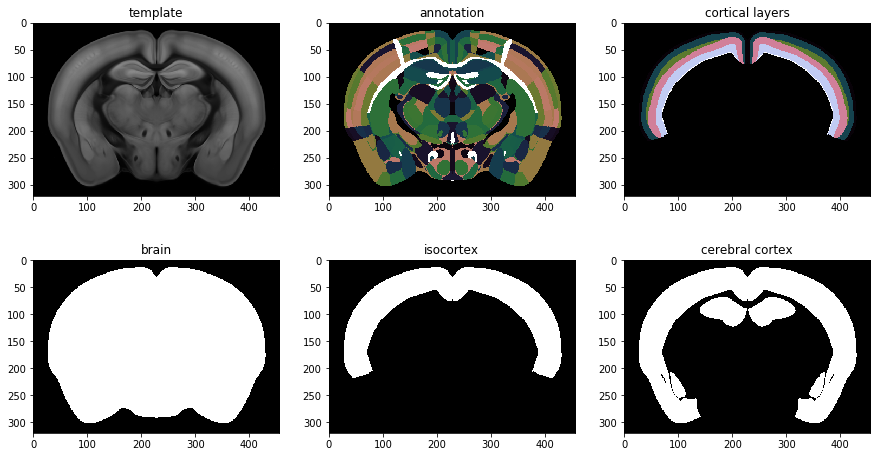

In [16]:
slice_idx = 264
f, ccf_axes = plt.subplots(2, 3, figsize=(15, 8))
ccf_axes[0,0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0,0].set_title("template")
ccf_axes[0,1].imshow(annot[slice_idx,:,:], cmap='cubehelix', aspect='equal', vmin=0, vmax=2000)
ccf_axes[0,1].set_title("annotation")
ccf_axes[0,2].imshow(layer_plot[slice_idx,:,:], cmap='cubehelix', aspect='equal')
ccf_axes[0,2].set_title("cortical layers")
ccf_axes[1,0].imshow(root_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[1,0].set_title("brain")
ccf_axes[1,1].imshow(cortex_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[1,1].set_title("isocortex")
ccf_axes[1,2].imshow(cc_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[1,2].set_title("cerebral cortex")
plt.show()